## Deterministic plan

This model is pretty much the exact same as developped in:
https://www.researchgate.net/profile/Tom_Schouwenaars/publication/240120004_Mixed_integer_programming_for_multi-vehicle_path-planning/links/00b7d531bba2714a9b000000.pdf

In [1]:
using JuMP, Gurobi, Plots, LinearAlgebra

In [2]:
GRB_ENV = Gurobi.Env();

Academic license - for non-commercial use only


### Create model for dynamics

In [3]:
T = 0.9
N = 9

9

In [4]:
dt = T/N
A = zeros(4,4)+I
A[1,2] = A[3,4] = dt
B = zeros(4,2)
B[2,1] = B[4,2] = dt
#C = zeros(2,4)
#C[1,2] = C[2,4] = 1
#D = zeros(2,2)
Bw = copy(B);

In [38]:
Krand = rand(N,N,2,2);
getK = (i,j) -> Krand[i,j,:,:]

#103 (generic function with 1 method)

In [83]:
w = randn(2, N);

In [108]:
Ak = zeros(N+1,size(A)...)
Ak[1,:,:] = zeros(Int, size(A))+I
for i=2:N+1
    Ak[i,:,:] = A*Ak[i-1,:,:]
end
Ai = i -> Ak[i+1,:,:]
x_k_det = (k,α) -> Ai(k-1)*x0+sum(Ai(k-i-2)*B*α[:,i+1] for i=0:k-2)
x_k_stoc = (k,α,K,w) -> (x_k_det(k,α)
    +sum((Ai(k-i-1)*Bw+sum(Ai(k-j-1)*B*K(j+1,i) for j=i+1:k-1))*w[:,i] for i=1:k-2)
    +Bw*w[:,k-1])

#223 (generic function with 1 method)

In [94]:
function xstoc(α,K,w)
    x = zeros(4,N)
    x[:, 1] = x0
    for k = 2:N
        u = α[:, k - 1]
        for i = 1:k-2
            u += K(k, i)*w[:,i]
        end
        x[:, k] = A*x[:, k-1] + Bw*w[:,k-1] + B*u
    end
    return x
end

xstoc (generic function with 1 method)

In [121]:
x_k_stoc(3, value.(u), getK, zeros(2,N))

4-element Array{Float64,1}:
 0.0037500000000000007
 0.037500000000000006
 0.006000000000000912
 0.0600000000000091

In [117]:
xstoc(value.(u), getK, zeros(2,N))

4×9 Array{Float64,2}:
 0.0  0.0     0.00375  0.0075  0.01125  0.015  0.02   0.025   0.03
 0.0  0.0375  0.0375   0.0375  0.0375   0.05   0.05   0.05    6.93889e-18
 0.0  0.0     0.006    0.012   0.018    0.024  0.03   0.0325  0.035
 0.0  0.06    0.06     0.06    0.06     0.06   0.025  0.025   0.0

In [113]:
value.(x)

4×9 Array{Float64,2}:
 0.0  0.0     0.00375  0.0075  0.01125  0.015  0.02   0.025   0.03
 0.0  0.0375  0.0375   0.0375  0.0375   0.05   0.05   0.05    0.0
 0.0  0.0     0.006    0.012   0.018    0.024  0.03   0.0325  0.035
 0.0  0.06    0.06     0.06    0.06     0.06   0.025  0.025   0.0

### Create model

In [70]:
x0 = [0;0;0;0]
xN = [0.03;0;0.035;0]
P = [-1 0; 0 1]
q = [-0.015; 0.03] 
Q = zeros(2,4)
Q[1,1] = Q[2,3] = -1
N1 = 2
M = 100;
epsilon = 0.00001

1.0e-5

In [6]:
#A1*x[[1,3],1] + M*z[1,:] -b1 
#x4 = value.(x)[[1,3],4]
#A1*x4-b1+M*[0;1]

Objective can be shortest time(using the variable g) or minimum fuel(au which is absolute u, aka control input).
For the minimum time we set a bounding box of epsilon around the goal and try to minimize the time to get to the goal state. 
For minimum fuel it will be a function of time, as long as the time is longer than the minimum time(the minimum time is constrained by the maximum control allowed!). The longer time we allow, the more efficient the path will be.

In [9]:
model = Model(optimizer_with_attributes(
        () -> Gurobi.Optimizer(GRB_ENV), #"OutputFlag" => 0
    ));
@variable(model, x[1:4, 1:N])
#@variable(model, y[1:2, 1:N])
@variable(model, u[1:2, 1:N-1])
@variable(model, au[1:2, 1:N-1] >=0)
@variable(model, z[1:N,1:2] >=0, Bin)
#@variable(model, g[1:N], Bin)
#@variable(model, ag[1:4, 1:N] >= 0)
@constraint(model, [k=1:N], P*Q*x[:,k] .<= -q + M*z[k,:] )
@constraint(model, c, sum(z, dims=2) .== N1-1)
@constraint(model, x[:,1] .== x0)
@constraint(model, x[:,N] .== xN)
@constraint(model, [k=1:N-1], x[:,k+1] .== A*x[:,k]+B*u[:,k])
#@constraint(model, [k=1:N-1], y[:,k+1] .== C*x[:,k]) #sensor output
@constraint(model, -au .<= u)
@constraint(model, u .<= au)
#@constraint(model, au .<= 0.5)
#@constraint(model, [k=1:N], -ag[:,k] .<= x[:, k] - xN)
#@constraint(model, [k=1:N], x[:, k] - xN .<= ag[:,k])
#@constraint(model, [k=1:N,i=1:4], -1000*g[k]+ag[i,k] .<= epsilon)
#@constraint(model, -1 .<= x[[2,4],:] .<= 1) # velocity constraint
#@objective(model, Min, sum(g));
@objective(model, Min, sum(au));

## Solve

In [12]:
optimize!(model);

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 99 rows, 86 columns and 222 nonzeros
Model fingerprint: 0x90d43d47
Variable types: 68 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Found heuristic solution: objective 12.0000000
Presolve removed 47 rows and 44 columns
Presolve time: 0.01s
Presolved: 52 rows, 42 columns, 138 nonzeros
Variable types: 36 continuous, 6 integer (6 binary)

Root relaxation: objective 1.857143e+00, 32 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.85714    0    2   12.00000    1.85714  84.5%     -    0s
H    0     0                       2.3571429    1.85714  21.2%     -    0s
     0     0    1.85714    0    2    2.35714    1.85714  21.2%   

In [13]:
xs = value.(x)[1,:]
ys = value.(x)[3,:];

In [14]:
value.(z)

9×2 Array{Float64,2}:
  0.0  1.0
  0.0  1.0
 -0.0  1.0
 -0.0  1.0
 -0.0  1.0
 -0.0  1.0
  1.0  0.0
  1.0  0.0
  1.0  0.0

In [15]:
rectangle(w, h, x, y) = Shape(ones(4)*x + [0,w,w,0], ones(4)*y + [0,0,h,h])

rectangle (generic function with 1 method)

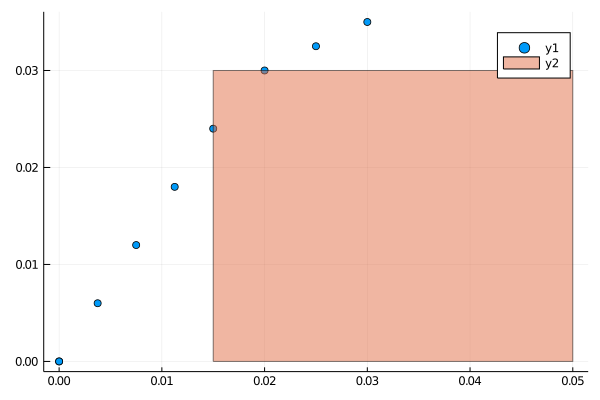

In [16]:
plot(xs, ys, seriestype = :scatter)
plot!(rectangle(0.035,0.03,0.015,0), opacity=.5)

In [20]:
x_k_det(8, value.(u))

4-element Array{Float64,1}:
 0.024999999999999998
 0.049999999999999996
 0.03250000000000227
 0.024999999999977256

In [19]:
value.(x)[:,8]

4-element Array{Float64,1}:
 0.025
 0.04999999999999999
 0.03250000000000228
 0.024999999999977256

In [68]:
Q = zeros(2,4)
Q[1,1] = Q[2,3] = -1
N_K = Int((N-2)*(N-1)/2) # number of K's
Ak = zeros(N+1,4,4)
Ak[1,:,:] = zeros(Int, size(A))+I
for i=2:N+1
    Ak[i,:,:] = A*Ak[i-1,:,:]
end
Ai = i -> Ak[i+1,:,:]
get_cone = (i,j) -> Int((i-2)*(i-3)/2)+j;

In [87]:
value.(x)[:,3]

4-element Array{Float64,1}:
 0.00375
 0.0375
 0.005
 0.06250000000001146

In [92]:
k = 2

2

In [97]:
x_k_det = (k,α) -> Ai(k-1)*x0+sum(Ai(k-i-2)*B*α[:,i+1] for i=0:k-2)

#203 (generic function with 1 method)

In [99]:
x_k_det(3, value.(u))

4-element Array{Float64,1}:
 0.0037500000000000007
 0.037500000000000006
 0.005000000000000001
 0.06250000000001146

In [100]:
x_k_det(9, value.(u))

4-element Array{Float64,1}:
 0.029999999999999995
 0.0
 0.03499999999999999
 3.469446951953614e-18

In [103]:
value.(x)[:,9]

4-element Array{Float64,1}:
 0.03
 0.0
 0.035
 0.0